In [6]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, LSTM, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import regularizers


import tensorflow as tf
from tensorflow.keras import layers
import chess
import numpy as np


In [7]:
def fen_to_board(fen):
    # Parse the FEN string
    parts = fen.split(" ")
    board_part = parts[0]
    isWhite = parts[1] == 'w'
    castling_part = parts[2]

    # Convert the board position to a binary matrix
    board = chess.Board(fen)
    binary_board = np.zeros((8, 8, 6), dtype=np.float32)
    piece_amount = np.zeros((12), dtype=np.float32)
    pieces = {'p': [0, 1.0], 'r': [1, 1.0], 'n': [2, 1.0], 'b': [3, 1.0], 'q': [4, 1.0], 'k': [5, 1.0],
              'P': [0, -1.0], 'R': [1, -1.0], 'N': [2, -1.0], 'B': [3, -1.0], 'Q': [4, -1.0], 'K': [5, -1.0]}
    
    for i in range(64):
        piece = board.piece_at(i)
        if piece:
            if isWhite:
                binary_board[i // 8, i % 8, pieces[str(piece)][0]] = pieces[str(piece)][1] 
            else:
                binary_board[7-(i // 8), 7-(i % 8), pieces[str(piece)][0]] = -pieces[str(piece)][1]
            if isWhite ^ (pieces[str(piece)][1] < 0):
                piece_amount[pieces[str(piece)][0]] += 1
            else:
                piece_amount[pieces[str(piece)][0]+6] += 1


    return [binary_board, piece_amount]


In [211]:
main_input = tf.keras.Input(shape=(8, 8, 6), name='main_input')
auxiliary_input = tf.keras.Input(shape=(12), name='auxiliary_input')

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(main_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (2, 2), activation='relu', padding='same')(x)

x = layers.Flatten()(x)
merged_input = layers.concatenate([x, auxiliary_input])

x = layers.Dense(256, activation='relu')(merged_input)
# x = layers.Dropout(0.5)(x)

output = layers.Dense(1)(x)

model = tf.keras.Model(inputs=[main_input, auxiliary_input], outputs=output)

model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae'])



In [212]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 main_input (InputLayer)     [(None, 8, 8, 6)]            0         []                            
                                                                                                  
 conv2d_74 (Conv2D)          (None, 8, 8, 8)              440       ['main_input[0][0]']          
                                                                                                  
 max_pooling2d_54 (MaxPooli  (None, 4, 4, 8)              0         ['conv2d_74[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_75 (Conv2D)          (None, 4, 4, 16)             1168      ['max_pooling2d_54[0][0

In [213]:
with open(r'processed_data\output_1.txt', 'r') as f:
    lines = f.readlines()

fens = [line.split()[0] + " " + line.split()[1] + " " + line.split()[2] for line in lines]
ratings = [-float(line.split()[-1]) if line.split()[1] == 'b' else float(line.split()[-1]) for line in lines]

# Separate the components into two arrays
binary_boards = []
piece_amounts = []

for fen in fens:
    binary_board, piece_amount = fen_to_board(fen)
    binary_boards.append(binary_board)
    piece_amounts.append(piece_amount)

binary_boards = np.array(binary_boards)
piece_amounts = np.array(piece_amounts)
ratings = np.array(ratings)


In [214]:
train_size = int(len(binary_boards) * 0.7)
val_size = int(len(binary_boards) * 0.15)

# Separate binary boards and piece amounts
x_binary_train, x_piece_train, y_train = binary_boards[:train_size], piece_amounts[:train_size], ratings[:train_size]
x_binary_val, x_piece_val, y_val = binary_boards[train_size:train_size + val_size], piece_amounts[train_size:train_size + val_size], ratings[train_size:train_size + val_size]
x_binary_test, x_piece_test, y_test = binary_boards[train_size + val_size:], piece_amounts[train_size + val_size:], ratings[train_size + val_size:]


In [24]:
from keras.models import load_model
model = load_model(r"TrainedModel.h5")
with open(r'ProcessedBotData.txt', 'r') as f:
    lines = f.readlines()

fens = [line.split()[0] + " " + line.split()[1] + " " + line.split()[2] for line in lines]
ratings = [-float(line.split()[-1]) if line.split()[1] == 'b' else float(line.split()[-1]) for line in lines]

# Separate the components into two arrays
binary_boards = []
piece_amounts = []

for fen in fens:
    binary_board, piece_amount = fen_to_board(fen)
    binary_boards.append(binary_board)
    piece_amounts.append(piece_amount)

binary_boards = np.array(binary_boards)
piece_amounts = np.array(piece_amounts)
ratings = np.array(ratings)

train_size = int(len(binary_boards) * 0.999)
val_size = int(len(binary_boards) * 0.15)

# Separate binary boards and piece amounts
x_binary_train, x_piece_train, y_train = binary_boards[:train_size], piece_amounts[:train_size], ratings[:train_size]
x_binary_val, x_piece_val, y_val = binary_boards[train_size:], piece_amounts[train_size:], ratings[train_size:]


In [25]:
history = model.fit([x_binary_train, x_piece_train], y_train, validation_data=([x_binary_val, x_piece_val], y_val), batch_size=64, epochs=7)

Epoch 1/7
49/49 [==============================] - 2s 13ms/step - loss: 0.0230 - mae: 0.0908 - val_loss: 0.0046 - val_mae: 0.0586
Epoch 2/7
49/49 [==============================] - 1s 10ms/step - loss: 0.0200 - mae: 0.0832 - val_loss: 0.0040 - val_mae: 0.0562
Epoch 3/7
49/49 [==============================] - 0s 10ms/step - loss: 0.0179 - mae: 0.0783 - val_loss: 0.0036 - val_mae: 0.0539
Epoch 4/7
49/49 [==============================] - 1s 11ms/step - loss: 0.0163 - mae: 0.0744 - val_loss: 0.0038 - val_mae: 0.0544
Epoch 5/7
49/49 [==============================] - 0s 10ms/step - loss: 0.0152 - mae: 0.0722 - val_loss: 0.0033 - val_mae: 0.0517
Epoch 6/7
49/49 [==============================] - 1s 10ms/step - loss: 0.0143 - mae: 0.0702 - val_loss: 0.0032 - val_mae: 0.0514
Epoch 7/7
49/49 [==============================] - 1s 11ms/step - loss: 0.0135 - mae: 0.0681 - val_loss: 0.0027 - val_mae: 0.0477


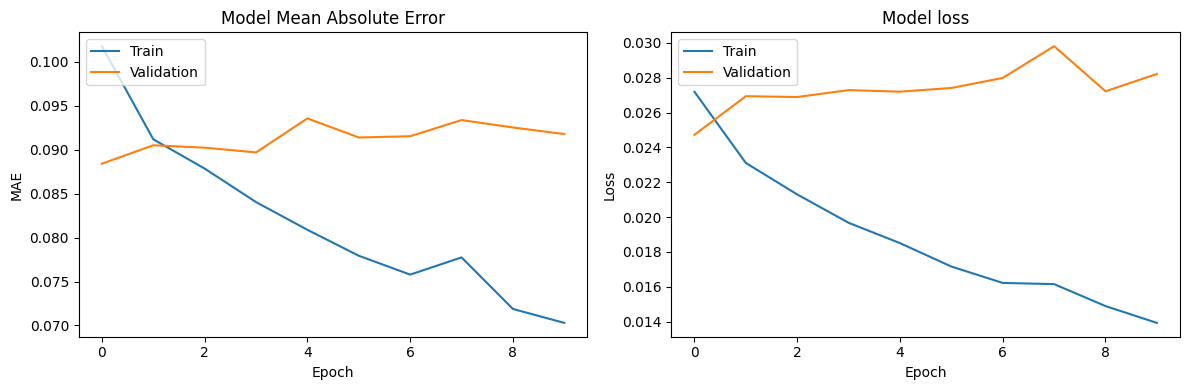

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation MAE values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'])  
plt.plot(history.history['val_mae']) 
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [26]:
model.save('TrainedModel2.h5')

In [11]:
import matplotlib.pyplot as plt
import numpy as np

x_test = [x_binary_test[:3000], x_piece_test[:3000]]
# Predict the ratings for the test data
y_pred = model.predict(x_test)

plt.figure(figsize=(10, 6))

# Scatter plot of actual vs predicted values
plt.plot(y_test[:3000], y_pred, marker='o', linestyle='None', markersize=2.0, label='Predictions')

# Line x=y for perfect predictions
plt.plot([-1, 1], [-1, 1], color='red', label='Optimal')

# Least squares fit line
coeff = np.polyfit(y_test[:3000].flatten(), y_pred.flatten(), 1)
fit_line = np.polyval(coeff, y_test[:3000].flatten())
plt.plot(y_test[:3000], fit_line, color='blue', label='Least Squares Fit')

plt.title('Actual vs Predicted Values')
plt.xlabel('Real value')
plt.ylabel('Predicted value')
plt.legend()

plt.show()

# Print the predicted and true ratings for the test data
for i in range(min(len(x_test), 300)):
    print(f"Predicted rating: {y_pred[i]}, True rating: {y_test[i]}")


NameError: name 'x_binary_test' is not defined

98/98 [==============================] - 1s 5ms/step


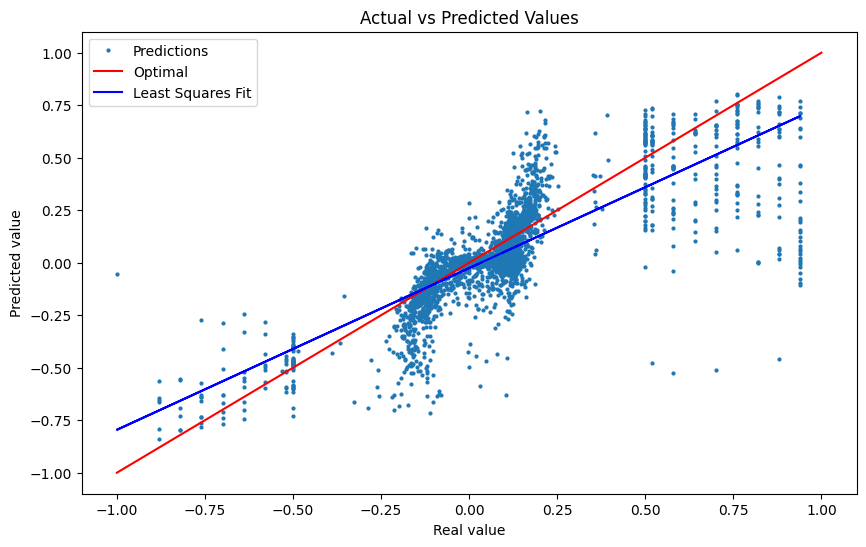

In [10]:
from keras.models import load_model
model = load_model(r"TrainedModel.h5")
with open(r'ProcessedBotData.txt', 'r') as f:
    lines = f.readlines()

fens = [line.split()[0] + " " + line.split()[1] + " " + line.split()[2] for line in lines]
ratings = [-float(line.split()[-1]) if line.split()[1] == 'b' else float(line.split()[-1]) for line in lines]

# Separate the components into two arrays
binary_boards2 = []
piece_amounts2 = []

for fen in fens:
    binary_board2, piece_amount2 = fen_to_board(fen)
    binary_boards2.append(binary_board2)
    piece_amounts2.append(piece_amount2)

binary_boards2 = np.array(binary_boards2)
piece_amounts2 = np.array(piece_amounts2)
ratings2 = np.array(ratings)

x_test2 = [binary_boards2, piece_amounts2]
y_pred2 = model.predict(x_test2)

plt.figure(figsize=(10, 6))

# Scatter plot of actual vs predicted values
plt.plot(ratings2, y_pred2, marker='o', linestyle='None', markersize=2.0, label='Predictions')

# Line x=y for perfect predictions
plt.plot([-1, 1], [-1, 1], color='red', label='Optimal')

# Least squares fit line
coeff2 = np.polyfit(ratings2.flatten(), y_pred2.flatten(), 1)
fit_line2 = np.polyval(coeff2, ratings2.flatten())
plt.plot(ratings2, fit_line2, color='blue', label='Least Squares Fit')

plt.title('Actual vs Predicted Values')
plt.xlabel('Real value')
plt.ylabel('Predicted value')
plt.legend()

plt.show()